In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
import math
from scipy.stats import norm
from scipy.optimize import curve_fit
import csv
import scipy.integrate as integrate
import scipy.stats as stats
import sympy as sp
import pandas as pd
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

plt.rcParams["figure.dpi"]=150

In [4]:

nombre_archivo = "muonAr.txt"
datos_tabla = pd.read_csv(nombre_archivo, sep=',') 
datos_tabla = datos_tabla.drop(datos_tabla.columns[:2], axis=1) 
datos_tabla = datos_tabla.drop(datos_tabla.columns[9], axis=1) 
xT=datos_tabla["T"]/1000
yE=datos_tabla["Ionization"]/(1000)
yE=yE*0.001662

In [5]:
class pixel:
    
    def __init__(self,xi,xf,yi,yf,zi,zf,idd):
        self.xi=xi
        self.xf=xf
        self.yi=yi
        self.yf=yf
        self.zi=zi
        self.zf=zf
        self.id=idd
        self.count=0 
        x = [self.xi, self.xf, self.xf, self.xi, self.xi, self.xi, self.xf, self.xf, self.xi, self.xi, self.xf, self.xf, self.xf, self.xi, self.xi,self.xf,self.xf]
        y = [self.yi, self.yi, self.yf, self.yf, self.yi, self.yi, self.yi, self.yf, self.yf, self.yi, self.yi, self.yi, self.yf, self.yf, self.yf,self.yf,self.yf]
        z = [self.zi, self.zi, self.zi, self.zi, self.zi, self.zf, self.zf, self.zf, self.zf, self.zf, self.zf, self.zi, self.zi, self.zi, self.zf,self.zf,self.zi]
        self.vertices=np.array((x,y,z))

    def getEquation(self):
        ax=self.xf-self.xi
        ay=self.yf-self.yi
        az=self.zf-self.zi
        region_equation = sp.And(sp.Abs(x - self.xi) - ax <= 0, sp.Abs(y - self.yi) - ay <= 0,sp.Abs(z - self.zi) - az <= 0)
        return region_equation
    
    def rotate(self,cenital,azimutal):
        vertices_cubo=self.vertices.T
        R_azimutal_inv = np.array([[np.cos(azimutal), -np.sin(azimutal), 0], [np.sin(azimutal), np.cos(azimutal), 0],[0, 0, 1]])
        R_cenital_inv = np.array([[1, 0, 0],[0, np.cos(cenital), -np.sin(cenital)],[0, np.sin(cenital), np.cos(cenital)]])
        vertices_cubo_rotado = np.dot(R_cenital_inv, np.dot(R_azimutal_inv, vertices_cubo.T)).T
        self.vertices=vertices_cubo_rotado.T
        return vertices_cubo_rotado.T

    def countUpdate(self):
        self.count+=1
      
    
    def coordenadas(self):
        return (self.xi,self.xf,self.yi,self.yf,self.zi,self.zf)
    
    def paint(self):
        x = [self.xi, self.xf, self.xf, self.xi, self.xi, self.xi, self.xf, self.xf, self.xi, self.xi, self.xf, self.xf, self.xf, self.xi, self.xi,self.xf,self.xf]
        y = [self.yi, self.yi, self.yf, self.yf, self.yi, self.yi, self.yi, self.yf, self.yf, self.yi, self.yi, self.yi, self.yf, self.yf, self.yf,self.yf,self.yf]
        z = [self.zi, self.zi, self.zi, self.zi, self.zi, self.zf, self.zf, self.zf, self.zf, self.zf, self.zf, self.zi, self.zi, self.zi, self.zf,self.zf,self.zi]
        return (x,y,z)

In [6]:
pix=pixel(-5,5,-5,5,-1,1,20)

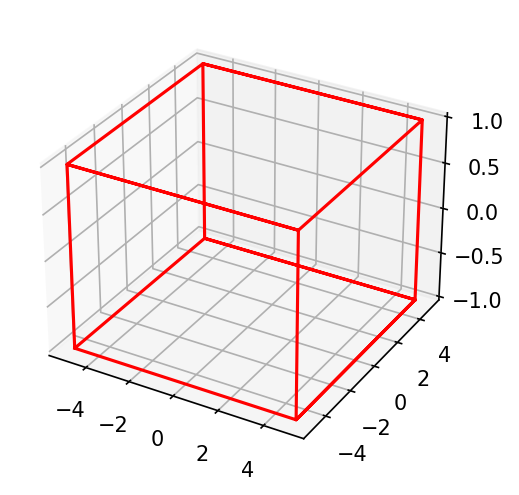

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xt,yt,zt=pix.paint()
ax.plot(xt,yt,zt, c='red')

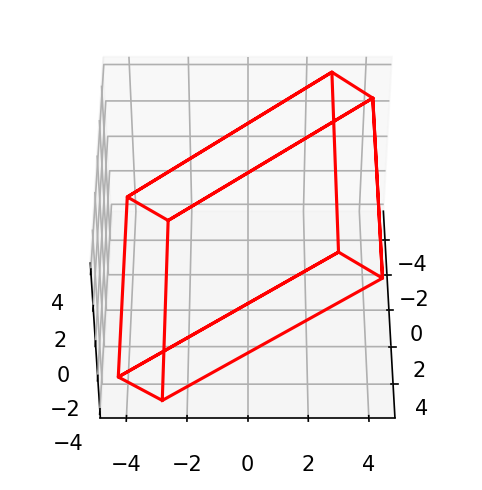

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xt,yt,zt=pix.rotate(np.pi/4,np.pi/2)
ax.plot(xt,yt,zt, c='red')
ax.view_init(elev=45, azim=0)

In [9]:
class detector:
    
    def __init__(self,x,y,z,r,xl,yl,zl):
        hx=xl/r
        hy=yl/r
        x1=x-(xl/2)
        y1=y-(yl/2)
        self.events=[]
        self.pixels=[]
        self.rotationC=0
        self.rotationA=0
        self.resolution=r
        self.x=xl
        self.y=yl
        self.z=zl
        self.x0=x
        self.y0=y
        self.z0=z
        
        xi=x1
        idd=0
        for i in range(r):
            xn=xi+hx
            
            yi=y1
            for j in range(r):
                yn=yi+hy
                self.pixels.append(pixel(xi,xn,yi,yn,z-(zl/2),z+(zl/2),idd))
                yi=yn
                idd=idd+1
            xi=xn
      
    
    def rotate(self,cenital,azimutal):
        self.rotationC=self.rotationC+cenital
        self.rotationA=self.rotationA+azimutal
        
        for i in self.pixels:
            i.rotate(cenital,azimutal)
            
    def getEvents(self,idd):
        self.pixels[idd].countUpdate()
        
    def getEnergy(self,E,t,distancia):
        diferencias_absolutas = np.abs(xT - E)
        indice_mas_cercano = np.argmin(diferencias_absolutas)
        E=yE[indice_mas_cercano]*distancia
        self.events.append([t,E])
             
            
    def isthere(self,x,y,z):
        k=-1
        L=np.array([x,y,z])
        cenital=-self.rotationC
        azimutal=-self.rotationA
        R_azimutal_inv = np.array([[np.cos(-azimutal), -np.sin(-azimutal), 0], [np.sin(-azimutal), np.cos(-azimutal), 0],[0, 0, 1]])
        R_cenital_inv = np.array([[1, 0, 0],[0, np.cos(-cenital), -np.sin(-cenital)],[0, np.sin(-cenital), np.cos(-cenital)]])
        L_rotado = np.dot(R_cenital_inv, np.dot(R_azimutal_inv, L.T)).T
        LA=L_rotado.T    
        
        
        for i in self.pixels:
            k=i.isthere(LA[0],LA[1],LA[2])
            if(k!=(-1)):
                return k
        return k               
        
        
    def isthereV3(self,vx,vy,vz,x,y,z):
        k=[]
        
        L=np.array([x,y,z])
        cenital=-self.rotationC
        azimutal=-self.rotationA
        R_azimutal_inv = np.array([[np.cos(-azimutal), -np.sin(-azimutal), 0], [np.sin(-azimutal), np.cos(-azimutal), 0],[0, 0, 1]])
        R_cenital_inv = np.array([[1, 0, 0],[0, np.cos(-cenital), -np.sin(-cenital)],[0, np.sin(-cenital), np.cos(-cenital)]])
        L_rotado = np.dot(R_cenital_inv, np.dot(R_azimutal_inv, L.T)).T
        LA=L_rotado.T 
  
        zD = LA[2]  
        xD = LA[0]
        yD = LA[1]
        
        x0=self.x0
        y0=self.y0
        z0=self.z0
        
        z_sup=z0+(self.z/2)
        z_inf=z0-(self.z/2)
        x_sup=x0+(self.x/2)
        x_inf=x0-(self.x/2)
        y_sup=y0+(self.y/2)
        y_inf=y0-(self.y/2)
      
      

        t_sup=(zD-z_sup)/vz
        t_inf=(zD-z_inf)/vz
        t_sup=t_sup+0.00000001
        
        x_inf_i=xD+vx*t_inf
        x_sup_i=xD+vx*t_sup
        y_sup_i=yD+vy*t_sup
        y_inf_i=yD+vy*t_inf
      
        ix_inf=int(((self.x/2)+x_inf_i)//(self.x/self.resolution))
        ix_sup=int(((self.x/2)+x_sup_i)//(self.x/self.resolution))
        
        iy_inf=int(((self.y/2)+y_inf_i)//(self.y/self.resolution))
        iy_sup=int(((self.y/2)+y_sup_i)//(self.y/self.resolution))
        
    
            
        i_inf=ix_inf*self.resolution + iy_inf
        i_sup=ix_sup*self.resolution + iy_sup
           
        i_next=-1
       
    
        if(ix_sup<self.resolution and iy_sup<self.resolution and ix_sup>=0 and iy_sup>=0):
           
            ix_next=ix_sup
            iy_next=iy_sup
            z_next=z_sup
            x_next=x_sup_i
            y_next=y_sup_i
            i_next=i_sup
            t_next=t_sup
           
        else:
            tx_sup,tx_inf,ty_sup,ty_inf=-1,-1,-1,-1
            if(vx!=0):
                tx_sup=(x_sup-xD)/vx
                tx_inf=(x_inf-xD)/vx
            if(vy!=0):
                ty_sup=(y_sup-yD)/vy
                ty_inf=(y_inf-yD)/vy
    
            arreglo=np.array([tx_sup,ty_sup,tx_inf,ty_inf]) 
           
            
            arreglo_sin_negativos = list(filter(lambda x: x >= 0, arreglo))
            if(len(arreglo_sin_negativos)==0):
                return 0
            t_next=min(arreglo_sin_negativos)
            while((zD-vz*t_next)>z_sup or ((xD+vx*t_next)<x_inf) or ((xD+vx*t_next)>x_sup) or ((yD+vy*t_next)<y_inf) or ((yD+vy*t_next)>y_sup)):
                arreglo_sin_negativos.remove(t_next)
                if(len(arreglo_sin_negativos)!=0):
                   
                    t_next=min(arreglo_sin_negativos)
                else:
                    return 0        
            t_next=t_next+0.00000001
            
            x_next=xD+vx*t_next
            y_next=yD+vy*t_next
            z_next=zD-vz*t_next
          
            ix_next=int(((self.x/2)+x_next)//(self.x/self.resolution))
            iy_next=int(((self.y/2)+y_next)//(self.y/self.resolution))
            
            i_next=ix_next*self.resolution + iy_next
            
            if(z_next<z_inf):
    
                i_next=-4
        if(i_sup==i_inf  and ix_sup<self.resolution and iy_sup<self.resolution and ix_sup>=0 and iy_sup>=0):
        
            t_v=t_sup-t_inf
            distancia= ((vx*t_v)**2+(vy*t_v)**2+(vz**2))**(0.5)
            return [distancia,[i_sup]]
        
        if(i_next>=0 ):
            t_v0=t_next
           
            while(ix_next<self.resolution and iy_next<self.resolution and z_next>=z_inf and ix_next>=0 and iy_next>=0):
                k.append(i_next)
                pixel=self.pixels[i_next]
                tx_pixel_sup,tx_pixel_inf,ty_pixel_sup,ty_pixel_inf=-1,-1,-1,-1
              
                if(vx!=0):
                    tx_pixel_sup=(pixel.xi-x_next)/vx
                    tx_pixel_inf=(pixel.xf-x_next)/vx
                if(vy!=0):
                    ty_pixel_sup=(pixel.yi-y_next)/vy
                    ty_pixel_inf=(pixel.yf-y_next)/vy
                
                arreglo=np.array([tx_pixel_sup,tx_pixel_inf,ty_pixel_sup,ty_pixel_inf])
            
                arreglo_sin_negativos = list(filter(lambda x: x > 0, arreglo))
                
                if(len(arreglo_sin_negativos)!=0):
                    t_next=(min(arreglo_sin_negativos))+0.00000001
        
                x_next=x_next+vx*t_next
                y_next=y_next+vy*t_next
                z_next=z_next-vz*t_next
            
                ix_next=int(((self.x/2)+x_next)//(self.x/self.resolution))
                iy_next=int(((self.y/2)+y_next)//(self.y/self.resolution))
            
                i_next=ix_next*self.resolution + iy_next
                    
            t_v=t_next-t_v0
            x_vuelo=vx*t_v
            y_vuelo=vy*t_v
            z_vuelo=vz*t_v
            
            distancia_vuelo=(((x_vuelo**2)+(y_vuelo**2)+(z_vuelo**2))**(0.5))
            return [distancia_vuelo,k]
        else:
            return 0
        
    
        

In [10]:
energyDistribution,AzimutalDistribution,zenitalDistribution= np.loadtxt("muones.txt")

In [11]:
class Telescope:
    
    def __init__(self,resolucion,s,Ancho,Largo,Grosor,z_init,cenital,Azimutal):
        self.dectector1=detector(0,0,z_init,resolucion,Ancho,Largo,Grosor)
        self.dectector2=detector(0,0,z_init-s,resolucion,Ancho,Largo,Grosor)
        self.dectector1.rotate(cenital,Azimutal)
        self.dectector2.rotate(cenital,Azimutal)
        self.rotationCenital=cenital
        self.rotationAzimutal=Azimutal
        self.Trayectoria=[]
        self.Zenital=[]
        
    def simulate(self,N=1000,z=3):
        dectector1=self.dectector1
        dectector2=self.dectector2
       
        l=0
        x_inf=(dectector1.x0-dectector1.x)*1.1
        x_sup=(dectector1.x0+dectector1.x)*1.1
        y_inf=(dectector1.y0-dectector1.y)*1.1
        y_sup=(dectector1.y0+dectector1.y)*1.1
        
        EnergiaMuon=[]
        
        Azimutal=[]
        z0=z

        while(l<N):
    
            x0=random.uniform(x_inf,x_sup)
            y0=random.uniform(y_inf,y_sup)
            
            vx =np.sin(zenitalDistribution[l]+self.rotationCenital)*np.cos(AzimutalDistribution[l]+self.rotationAzimutal)
            vy = np.sin(zenitalDistribution[l]+self.rotationCenital)*np.sin(AzimutalDistribution[l]+self.rotationAzimutal)
            vz = np.cos(zenitalDistribution[l]+self.rotationCenital)
    
    
            resultado=dectector1.isthereV3(vx,vy,vz,x0,y0,z0)
            EnergiaMuon.append(energyDistribution[l])
            if(resultado!=0 and len(resultado[1])!=0):
                distancia=resultado[0]
                k=resultado[1]
                for i in k:
                    dectector1.getEvents(i)
                    
                dectector1.getEnergy(energyDistribution[l],l,distancia)
                
                
            resultado2=dectector2.isthereV3(vx,vy,vz,x0,y0,z0)
        
            if(resultado2!=0 and len(resultado2[1])!=0):
                distancia2=resultado2[0]
                k2=resultado2[1]
                for i in k2:
                    dectector2.getEvents(i)
                dectector2.getEnergy(energyDistribution[l],l,distancia2)
                
            if(resultado!=0 and resultado2!=0 and len(resultado2[1])!=0 and len(resultado[1])!=0):
                self.Trayectoria.append([k[0],k2[0]])
               # X.append([vx,vy,vz,x0,y0,z0])
                self.Zenital.append(zenitalDistribution[l])
                #Azimutal.append(AzimutalDistribution[l])
            l=l+1
    
    def calculate(self):
        Angulo=[]
        AnguloX=[]
        AnguloY=[]
        AngularResolution=[]
        AnguloAzimutal=[]
        Eventos=np.array(self.dectector1.events)
        Eventos2=np.array(self.dectector2.events)
        Energy=Eventos[:,1]
        Energy2=Eventos2[:,1]
        sF=0
        dif=[]
        AnchoDetector=self.dectector1.x
        Resolucion=self.dectector1.resolution
        DistanciaZ=np.abs(self.dectector1.z0-self.dectector2.z0)
        print(AnchoDetector,Resolucion,DistanciaZ)
        resolutionA= np.arctan((((AnchoDetector/Resolucion)**2)/DistanciaZ))
        px1=[]
        px2=[]
        py1=[]
        py2=[]
        pz1=[]
        pz2=[]
        
        for i in self.Trayectoria:
            
            Ancho_X_Pix=(i[0]//Resolucion)-(i[1]//Resolucion)
            Ancho_Y_Pix=(i[0]%Resolucion)-(i[1]%Resolucion)
        
            Ancho_X=Ancho_X_Pix*AnchoDetector/Resolucion
            Ancho_Y=Ancho_Y_Pix*AnchoDetector/Resolucion
          
            Distancia=np.sqrt((Ancho_X**2)+(Ancho_Y**2))
            
            D=((Distancia**2)+(DistanciaZ**2))**(0.5)
            ang=Distancia/DistanciaZ
            if(Ancho_X_Pix<0):
                ang=-ang
            Angulo.append(np.arctan(ang)+self.rotationCenital)
            
            angs=np.arctan(ang)
            AngularResolution.append(((AnchoDetector/Resolucion)**2)/D)
            AnguloX.append(np.arctan(Ancho_X/DistanciaZ))
            AnguloY.append(np.arctan(Ancho_Y/DistanciaZ))
            dif.append(np.abs((np.abs(self.Zenital[sF])-np.abs(angs))))
            if(Ancho_Y!=0):
                AnguloAzimutal.append(np.arctan(np.abs(Ancho_X/Ancho_Y)))
                vx =np.sin(Angulo[-1])*np.cos(AnguloAzimutal[-1])
                vy = np.sin(Angulo[-1])*np.sin(AnguloAzimutal[-1])
                vz = np.cos(Angulo[-1])
                px1.append((Energy[sF])*vx*1.2e5)
                px2.append((Energy2[sF])*vx*1.2e5)
                py1.append((Energy[sF])*vy*1.2e5)
                py2.append((Energy2[sF])*vy*1.2e5)
                pz1.append((Energy[sF])*vz*1.2e5)
                pz2.append((Energy2[sF])*vz*1.2e5)
                
                
                
            #if(np.abs((np.abs(Zenital[sF])-np.abs(angs))/Zenital[sF])>0.8):
                #print(X[sF])
                #print(i,Ancho_X,Ancho_Y)
                #print(angs,Zenital[sF],np.abs(((np.abs(Zenital[sF])-np.abs(angs))/Zenital[sF])))
                #print(np.arctan(Distancia/2),Ancho_X,Ancho_Y,Zenital[sF])
            #Acceptancia.append(AngularResolution[-1]*((AnchoDetector/Resolucion)**2)*Surface[sF]) 
            sF=sF+1
        AnguloX=np.array(AnguloX)
        AnguloY=np.array(AnguloY)
        AngularResolution=np.array(AngularResolution)
       
        return AnguloX,AnguloY,AngularResolution,px1,px2,py1,py2,pz1,pz2,Angulo

In [12]:
class TelescopeP2:
    
    def __init__(self,N,resolucion,distancia,Ancho,Grosor,z_init,cenital,Azimutal):
        self.dectectors=[]
        for i in range(N):
            self.dectectors.append(detector(0,0,z_init-(distancia*i),resolucion,Ancho,Ancho,Grosor))
            self.dectectors[-1].rotate(cenital,Azimutal)
     
        self.rotationCenital=cenital
        self.rotationAzimutal=Azimutal
        self.Resolution=resolucion
        self.Trayectoria=[]
        self.Zenital=[]
        self.Ndec=N
        
    def simulate(self,N=1000,z0=3):
        l=0
        dectector1=self.dectectors[0]
        x_inf=(dectector1.x0-dectector1.x)*1.1
        x_sup=(dectector1.x0+dectector1.x)*1.1
        y_inf=(dectector1.y0-dectector1.y)*1.1
        y_sup=(dectector1.y0+dectector1.y)*1.1
        
        Azimutal=[]
        
        while(l<N):
    
            x0=random.uniform(x_inf,x_sup)
            y0=random.uniform(y_inf,y_sup)
            
            vx =np.sin(zenitalDistribution[l]+self.rotationCenital)*np.cos(AzimutalDistribution[l]+self.rotationAzimutal)
            vy = np.sin(zenitalDistribution[l]+self.rotationCenital)*np.sin(AzimutalDistribution[l]+self.rotationAzimutal)
            vz = np.cos(zenitalDistribution[l]+self.rotationCenital)
            
            trayDec=[]
            for j in range(self.Ndec):
                resultado=self.dectectors[j].isthereV3(vx,vy,vz,x0,y0,z0)
              
                if(resultado!=0 and len(resultado[1])!=0):
                    distancia=resultado[0]
                    k=resultado[1]
                    trayDec.append(k[0])
                    for i in k:
                        self.dectectors[j].getEvents(i)
                    self.dectectors[j].getEnergy(energyDistribution[l],l,distancia)
                else:
                    trayDec.append(-1)
            self.Trayectoria.append(trayDec)
            self.Zenital.append(zenitalDistribution[l])
            l=l+1
        return self.Trayectoria
    
    def paint(self):
        r=self.Resolution
        N=self.Ndec
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        for i in range(N):
            dec=self.dectectors[i]
            x00=[min(dec.pixels[0].vertices[0]),min(dec.pixels[0].vertices[1]),min(dec.pixels[0].vertices[2])]
            x01=[min(dec.pixels[0].vertices[0]),min(dec.pixels[0].vertices[1]),max(dec.pixels[0].vertices[2])]
            x10=[min(dec.pixels[r-1].vertices[0]),max(dec.pixels[r-1].vertices[1]),min(dec.pixels[r-1].vertices[2])]
            x11=[min(dec.pixels[r-1].vertices[0]),max(dec.pixels[r-1].vertices[1]),max(dec.pixels[r-1].vertices[2])]
            x20=[max(dec.pixels[(r*(r-1))].vertices[0]),min(dec.pixels[(r*(r-1))].vertices[1]),min(dec.pixels[(r*(r-1))].vertices[2])]
            x21=[max(dec.pixels[(r*(r-1))].vertices[0]),min(dec.pixels[(r*(r-1))].vertices[1]),max(dec.pixels[(r*(r-1))].vertices[2])]
            x30=[max(dec.pixels[(r*r-1)].vertices[0]),max(dec.pixels[(r*r-1)].vertices[1]),min(dec.pixels[(r*r-1)].vertices[2])]
            x31=[max(dec.pixels[(r*r-1)].vertices[0]),max(dec.pixels[(r*r-1)].vertices[1]),max(dec.pixels[(r*r-1)].vertices[2])]
            vertices=np.array([x01,x00,x10,x11,x10,x30,x31,x30,x20,x21,x20,x00,x01,x11,x31,x21,x01])
            X=vertices[:,0]
            Y=vertices[:,1]
            Z=vertices[:,2]
            ax.plot(X,Y,Z, label='Trayectoria')
        
        ax.view_init(elev=0, azim=45)

        plt.show()
        
    
    def calculate(self,i,j):
        
        Angulo=[]
        AnguloAzimutal=[]
        px1=[]
        px2=[]
        py1=[]
        py2=[]
        pz1=[]
        pz2=[]
        
        Eventos=np.array(self.dectectors[i].events)
        Eventos2=np.array(self.dectectors[j].events)
        Energy=Eventos[:,1]
        Energy2=Eventos2[:,1]
        
            

        
        AnchoDetector=self.dectectors[i].x
        Resolucion=self.dectectors[i].resolution
        DistanciaZ=np.abs(self.dectectors[i].z0-self.dectectors[j].z0)
        Res=Resolucion
        pix=np.array(self.dectectors[i].pixels)
        pix=pix.reshape((Res,Res))
        im=np.zeros((Res,Res))
        for i1 in range(Res):
            for j1 in range(Res):
                im[i1][j1]=pix[i1][j1].count
                
        pix2=np.array(self.dectectors[j].pixels)
        pix2=pix.reshape((Res,Res))
        im2=np.zeros((Res,Res))
        for i2 in range(Res):
            for j2 in range(Res):
                im2[i2][j2]=pix2[i2][j2].count
        sF=0
        
        for t in self.Trayectoria:
            if(t[i]!=-1 and t[j]!=-1):
                Ancho_X_Pix=(t[i]//Resolucion)-(t[j]//Resolucion)
                Ancho_Y_Pix=(t[i]%Resolucion)-(t[j]%Resolucion)
        
                Ancho_X=Ancho_X_Pix*AnchoDetector/Resolucion
                Ancho_Y=Ancho_Y_Pix*AnchoDetector/Resolucion
          
                Distancia=np.sqrt((Ancho_X**2)+(Ancho_Y**2))
            
                D=((Distancia**2)+(DistanciaZ**2))**(0.5)
                ang=Distancia/DistanciaZ
                if(Ancho_X_Pix<0):
                    ang=-ang
                Angulo.append(np.arctan(ang)+self.rotationCenital)
            
                angs=np.arctan(ang)
                if(Ancho_Y!=0):
                    AnguloAzimutal.append(np.arctan(np.abs(Ancho_X/Ancho_Y)))
                    vx =np.sin(Angulo[-1])*np.cos(AnguloAzimutal[-1])
                    vy = np.sin(Angulo[-1])*np.sin(AnguloAzimutal[-1])
                    vz = np.cos(Angulo[-1])
                    px1.append((Energy[sF])*vx*1.2e5)
                    px2.append((Energy2[sF])*vx*1.2e5)
                    py1.append((Energy[sF])*vy*1.2e5)
                    py2.append((Energy2[sF])*vy*1.2e5)
                    pz1.append((Energy[sF])*vz*1.2e5)
                    pz2.append((Energy2[sF])*vz*1.2e5)
                
                sF=sF+1
   
        return px1,px2,py1,py2,pz1,pz2,Angulo, AnguloAzimutal,Energy,Energy2,im,im2

In [32]:
#Numero_Detectores,resolucion,distancia_entre_ellas,Ancho,Grosor,z_init,cenital,Azimutal
teles=TelescopeP2(3,512,5,10,0.3,4,np.pi/4,0)

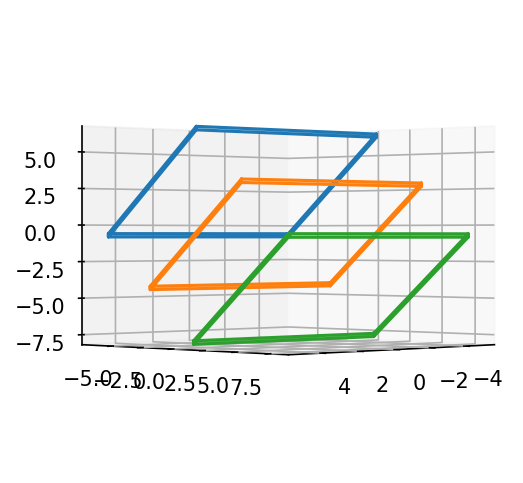

In [33]:
teles.paint()


In [34]:
%%time
Resu=teles.simulate(2000000,6)

Wall time: 17min 37s


In [35]:
Resu

[[170438, 217079, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, 221229, 143411],
 [-1, -1, 37049],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [134164, -1, -1],
 [-1, -1, -1],
 [61983, -1, -1],
 [-1, -1, -1],
 [62683, 82128, 101573],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [44342, -1, -1],
 [6894, 36030, 65166],
 [54495, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [-1, -1, -1],
 [81399, -1, -1],
 [80802, -1, -1],
 [149053, 187592, 225620],
 [-1, -1, -1],
 [-1, 154349, -1],
 [-1, -1, 52463],
 [-1, -1, -1],
 [195202, -1, -1],
 [-1, 

In [36]:
px1,px2,py1,py2,pz1,pz2,Angulo, AnguloAzimutal,Energy,Energy2,im,im2=teles.calculate(0,2)

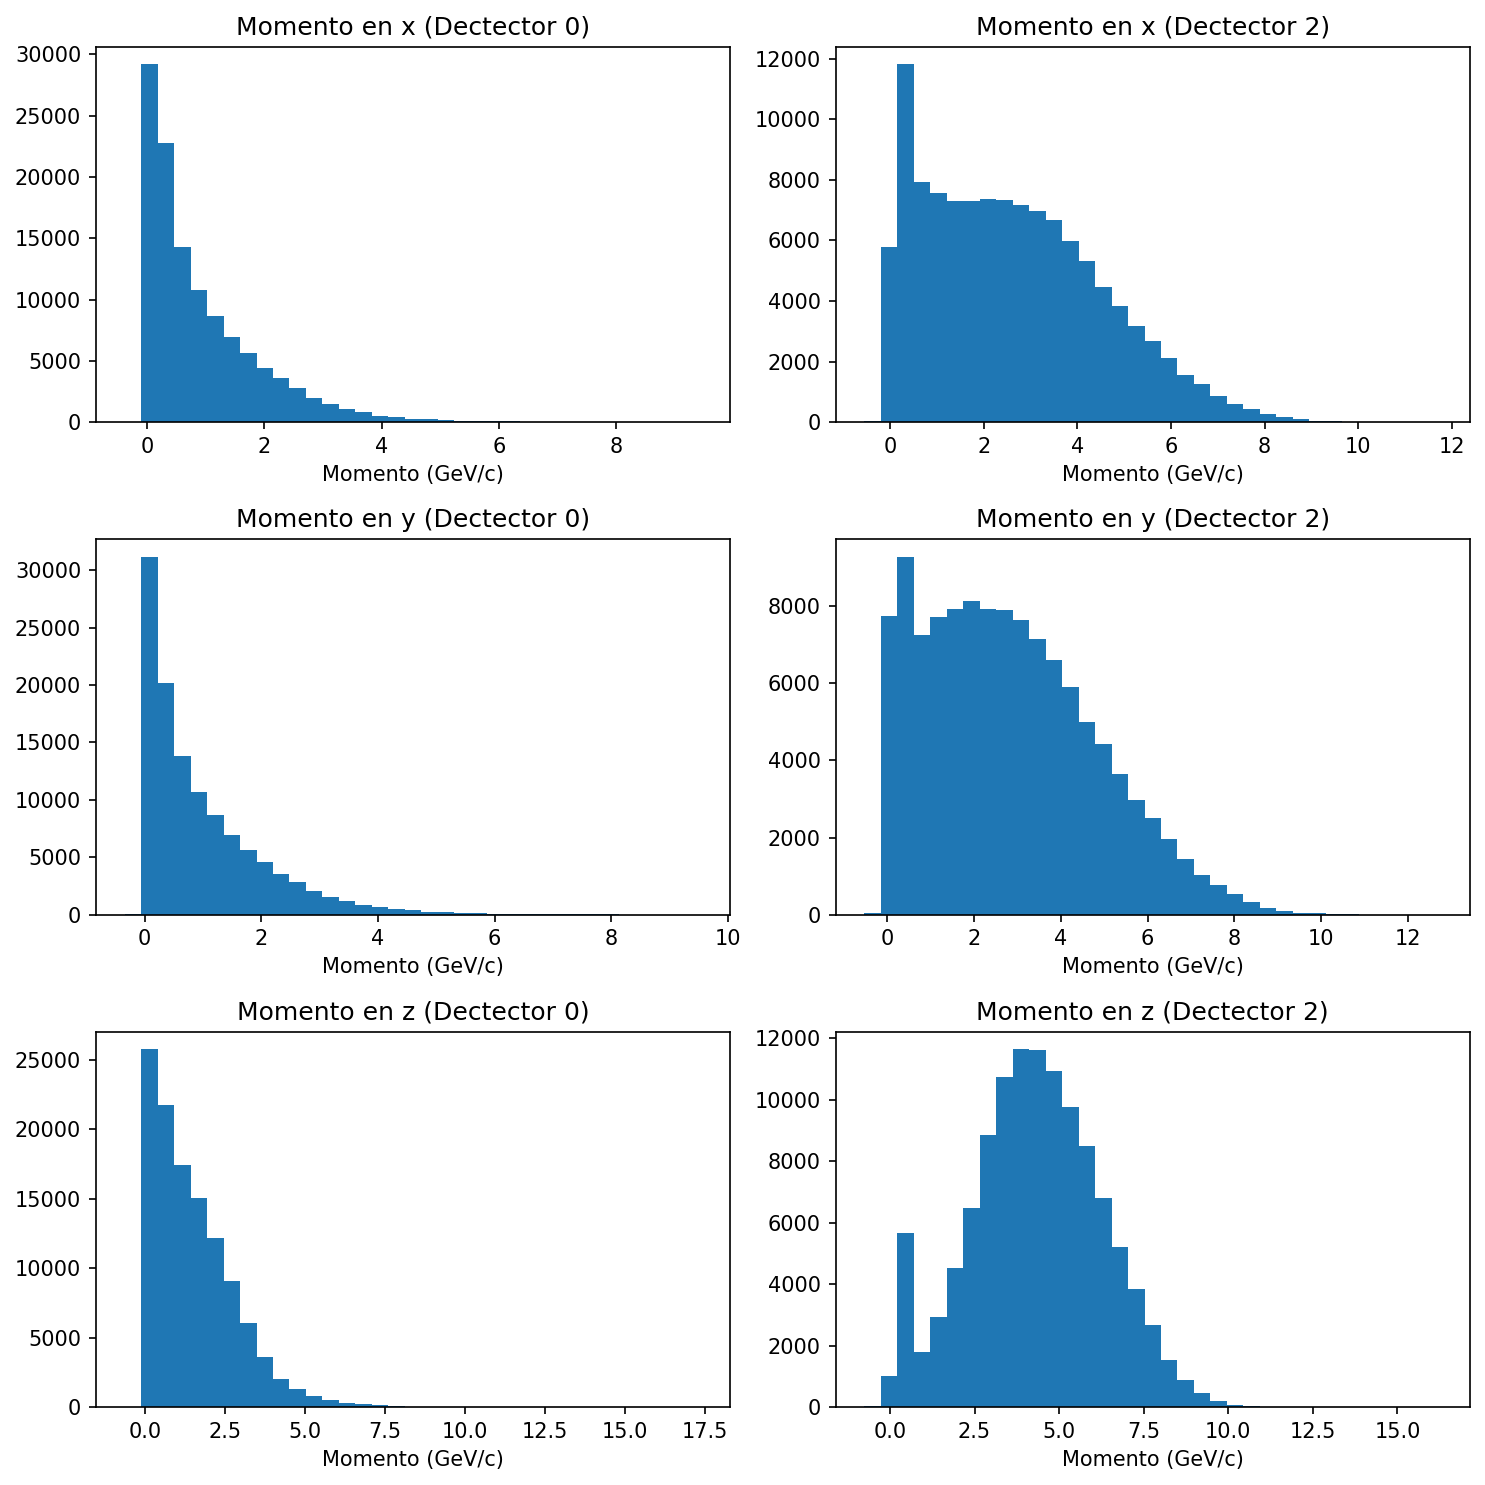

In [37]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Subplot 1
axs[0, 0].hist(px1,bins=35)
axs[0, 0].set_title('Momento en x (Dectector 0)')
axs[0, 0].set_xlabel("Momento (GeV/c)")

# Subplot 2
axs[0, 1].hist(px2,bins=35)
axs[0, 1].set_title('Momento en x (Dectector 2)')
axs[0, 1].set_xlabel("Momento (GeV/c)")
# Subplot 3
axs[1, 0].hist(py1,bins=35)
axs[1, 0].set_title('Momento en y (Dectector 0)')
axs[1, 0].set_xlabel("Momento (GeV/c)")
# Subplot 4
axs[1, 1].hist(py2,bins=35)
axs[1, 1].set_title('Momento en y (Dectector 2)')
axs[1, 1].set_xlabel("Momento (GeV/c)")
# Subplot 5
axs[2, 0].hist(pz1,bins=35)
axs[2, 0].set_title('Momento en z (Dectector 0)')
axs[2, 0].set_xlabel("Momento (GeV/c)")
# Subplot 6
axs[2, 1].hist(pz2,bins=35)
axs[2, 1].set_title('Momento en z (Dectector 2)')
axs[2, 1].set_xlabel("Momento (GeV/c)")
# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar los subplots
plt.show()

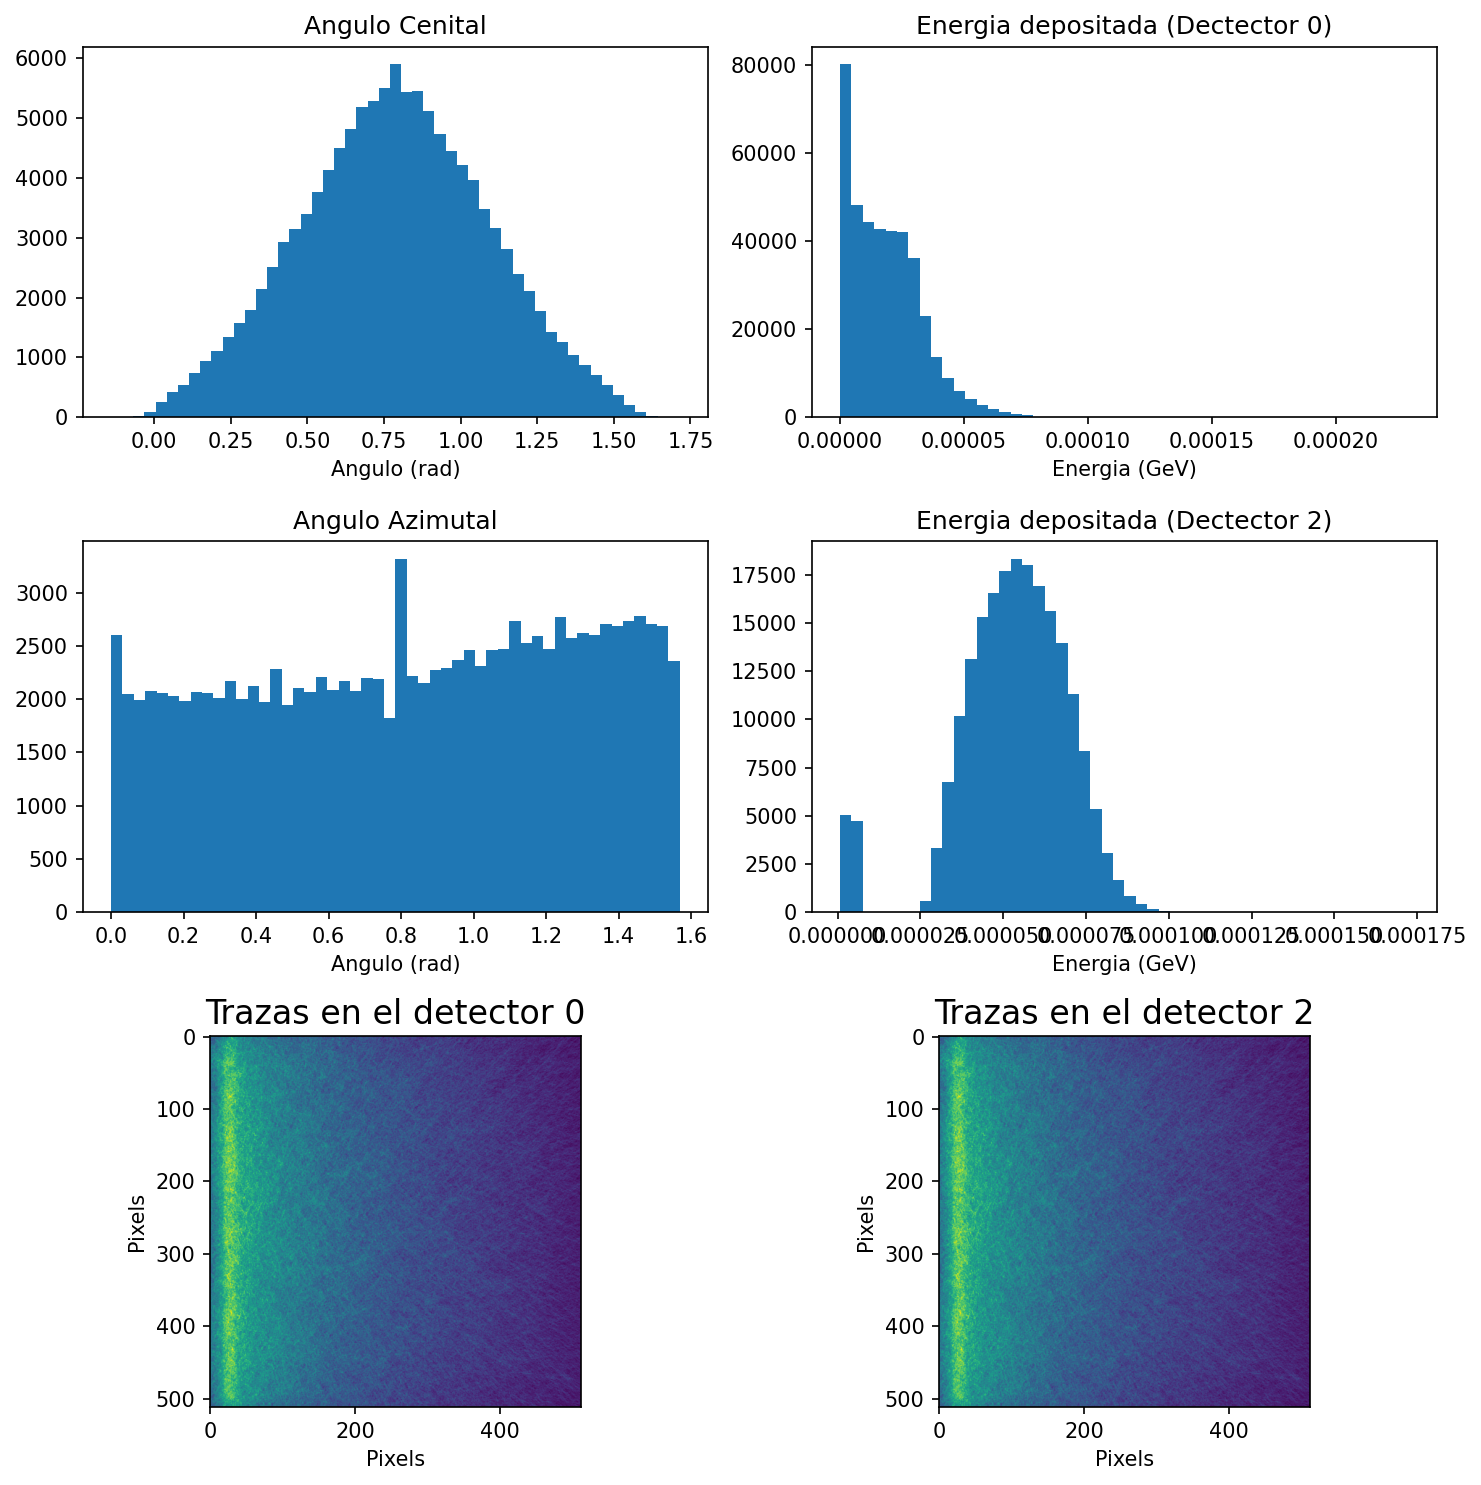

In [38]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Subplot 1
axs[0, 0].hist(Angulo,bins=51)
axs[0, 0].set_title('Angulo Cenital')
axs[0, 0].set_xlabel("Angulo (rad)")

# Subplot 2
axs[1, 0].hist(AnguloAzimutal,bins=50)
axs[1, 0].set_title('Angulo Azimutal')
axs[1, 0].set_xlabel("Angulo (rad)")
# Subplot 3
axs[0, 1].hist(Energy,bins=50)
axs[0, 1].set_title('Energia depositada (Dectector 0)')
axs[0, 1].set_xlabel("Energia (GeV)")
# Subplot 4
axs[1, 1].hist(Energy2,bins=50)
axs[1, 1].set_title('Energia depositada (Dectector 2)')
axs[1, 1].set_xlabel("Energia (GeV)")

axs[2,0].imshow(im)
axs[2,0].set_title("Trazas en el detector 0",fontsize=16)
axs[2,0].set_xlabel("Pixels")
axs[2,0].set_ylabel("Pixels")

axs[2,1].imshow(im2)
axs[2,1].set_title("Trazas en el detector 2",fontsize=16)
axs[2,1].set_xlabel("Pixels")
axs[2,1].set_ylabel("Pixels")

# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar los subplots
plt.show()

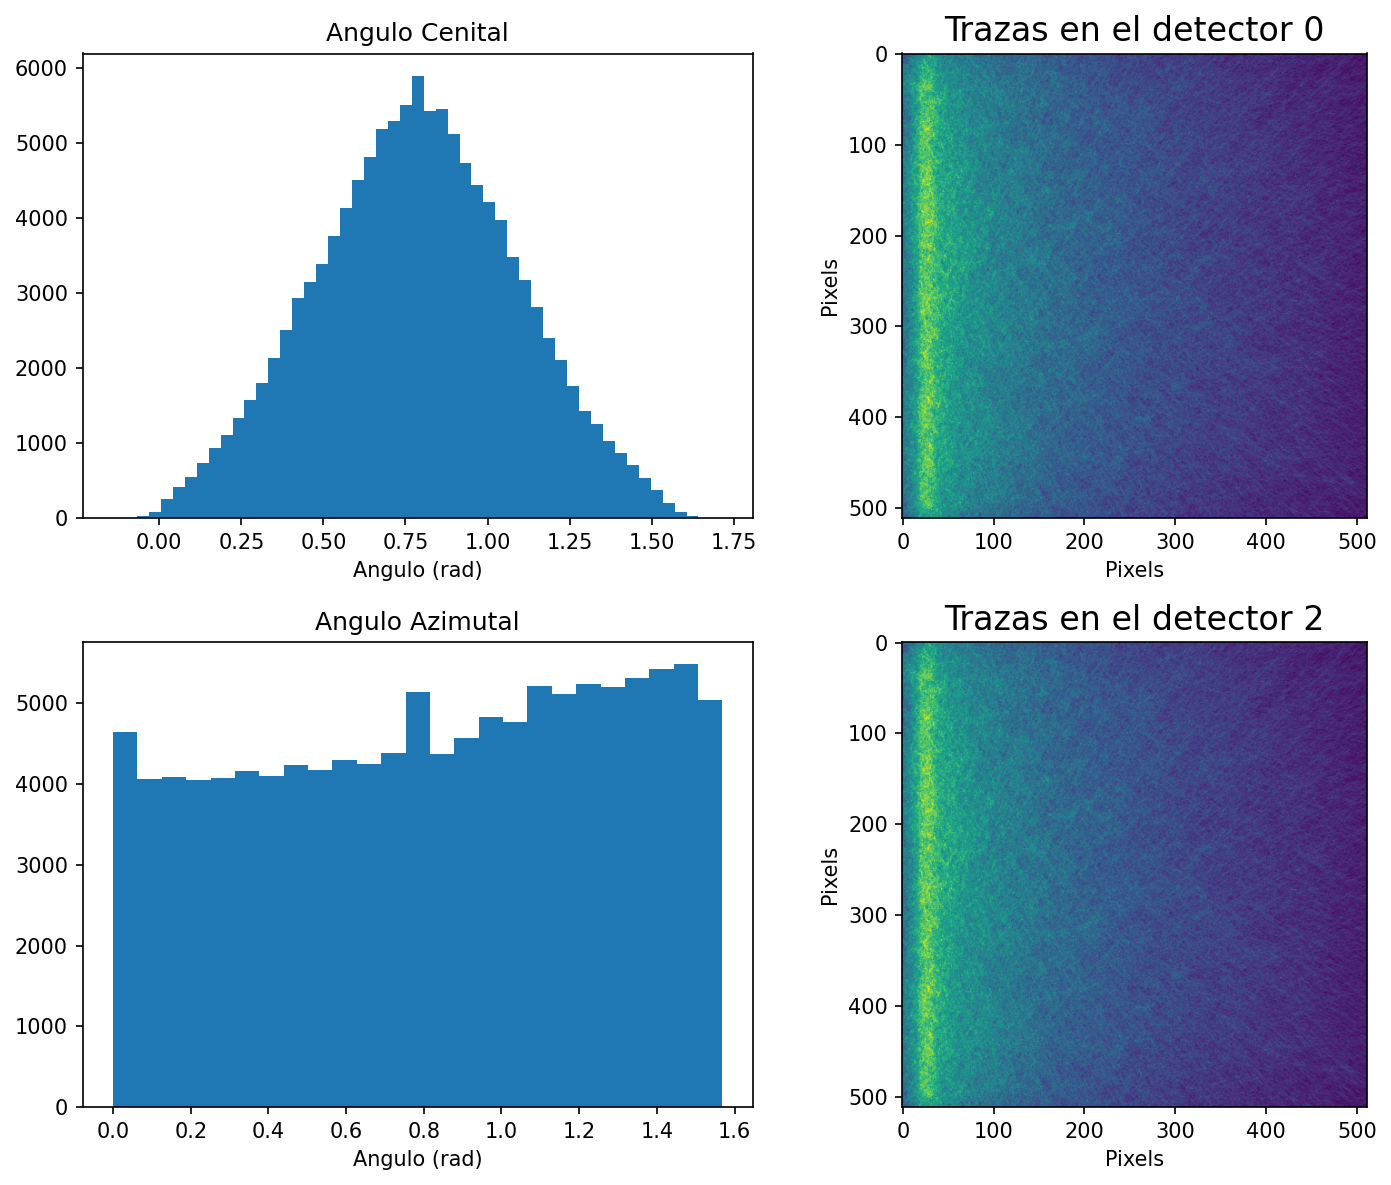

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Subplot 1
axs[0, 0].hist(Angulo,bins=51)
axs[0, 0].set_title('Angulo Cenital')
axs[0, 0].set_xlabel("Angulo (rad)")

# Subplot 2
axs[1, 0].hist(AnguloAzimutal,bins=25)
axs[1, 0].set_title('Angulo Azimutal')
axs[1, 0].set_xlabel("Angulo (rad)")

axs[0,1].imshow(im)
axs[0,1].set_title("Trazas en el detector 0",fontsize=16)
axs[0,1].set_xlabel("Pixels")
axs[0,1].set_ylabel("Pixels")

axs[1,1].imshow(im2)
axs[1,1].set_title("Trazas en el detector 2",fontsize=16)
axs[1,1].set_xlabel("Pixels")
axs[1,1].set_ylabel("Pixels")

# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar los subplots
plt.show()

In [55]:
Angulo=[]
AnguloX=[]
AnguloY=[]
AngularResolution=[]
Acceptancia=[]
AnchoDetector=10
Resolucion=128
Pixeles=np.linspace(0,Resolucion*Resolucion-1,Resolucion*Resolucion)
DistanciaZ=1.5
sF=0
PixelCentral=int(Resolucion*Resolucion/2)
for i in Pixeles:
    Ancho_X_Pix=(i//Resolucion)-(63)
    Ancho_Y_Pix=np.abs((i%Resolucion)-(63))
    Ancho_X=Ancho_X_Pix*AnchoDetector/Resolucion
    Ancho_Y=Ancho_Y_Pix*AnchoDetector/Resolucion
    Distancia=((Ancho_X**2)+(Ancho_Y**2))**(0.5)
    D=((Distancia**2)+(DistanciaZ**2))**(0.5)
    angRes=((AnchoDetector/Resolucion)**2)/(D**2)
    
    AngularResolution.append(angRes)
    Angulo.append(np.arctan(Distancia/DistanciaZ))
    AnguloX.append(np.arctan(Ancho_X/DistanciaZ))
    AnguloY.append(np.arctan(Ancho_Y/DistanciaZ))
    
    Acceptancia.append(AngularResolution[-1]*AnchoDetector*AnchoDetector) 
        
        
    sF=sF+1
    
AnguloX=np.array(AnguloX)
AnguloY=np.array(AnguloY)
AngularResolution=np.array(AngularResolution)
Acceptancia=np.array(Acceptancia)

In [56]:
np.shape(AngularResolution)

(16384,)

In [57]:
AngularResolution=AngularResolution.reshape(128,128)

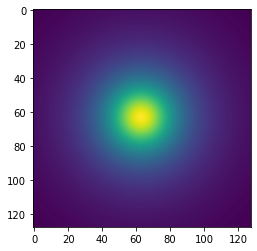

In [58]:
plt.imshow(AngularResolution)

In [59]:
Acceptancia=Acceptancia.reshape(128,128)

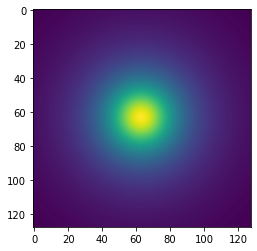

In [60]:
plt.imshow(Acceptancia)

In [61]:
x = np.linspace(min(AnguloX),max(AnguloX) , 128)
y = np.linspace(min(AnguloY),max(AnguloY) , 128)
X, Y = np.meshgrid(x, y)
Z = AngularResolution

In [62]:
np.shape(Y)

(128, 128)

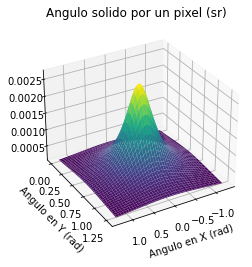

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d',)
ax.plot_surface(X, Y, Z, cmap='viridis')


ax.view_init(elev=30, azim=60)
# Mostrar el gráfico
plt.title("Angulo solido por un pixel (sr)")
plt.xlabel("Angulo en X (rad)")
plt.ylabel("Angulo en Y (rad)")

plt.show()

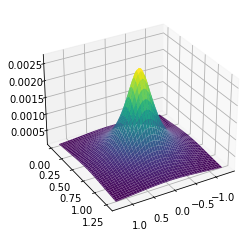

In [64]:
x = np.linspace(min(AnguloX),max(AnguloX) , 128)
y = np.linspace(min(AnguloY),max(AnguloY) , 128)
X, Y = np.meshgrid(x, y)
Z = AngularResolution
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d',)
ax.plot_surface(X, Y, Z, cmap='viridis')


ax.view_init(elev=30, azim=60)
# Mostrar el gráfico
plt.show()